# Contrastive Explanation Method
## Table of content:
* [Imports](#imports)
* [Performance of the CEM on the MNIST dataset](#potcotmd)
* [Training the MNIST classifier](#training_mnist_classifier)
* [Training the MNIST autoencoder](#training_mnist_ae)
* [MNIST Contrastive Explanation Method](#cem_mnist)
* [Evaluate MNIST Contrastive Explanation Method](#eval_cem_mnist)
* [Performance of the CEM on the Fashion MNIST dataset](#potcotfd)
* [Training the Fashion MNIST classifier](#training_fashion_mnist_classifier)
* [Training the Fashion MNIST autoencoder](#training_fashion_mnist_ae)
* [Fashion MNIST Contrastive Explanation Method](#cem_fashion_mnist)
* [Evaluate Fashion MNIST Contrastive Explanation Method](#eval_cem_fashion_mnist)

# Imports <a class="anchor" id="imports"></a>

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import time
import os

import torch

from cem.datasets.mnist import MNIST
from cem.datasets.fashion_mnist import FashionMNIST

from cem.models.cae_model import CAE
from cem.models.conv_model import CNN

from cem.train import train_ae, train_cnn

from cem.cem import ContrastiveExplanationMethod

# set random seeds for reproducability (although the CEM is fully determininstic)
torch.manual_seed(0)
np.random.seed(0)

In [2]:
# Change the following variables to either include or skip over optional
# evaluation metrics for the CNN and autoencoder
EVALUATE_CNN = True
EVALUATE_AUTOENCODER = True

# Change these variables to force (re-)download of the datasets
DOWNLOAD_MNIST = False
DOWNLOAD_FASHION_MNIST = False

# Device on which experiments are run
DEVICE = 'cpu'

# Performance of the CEM on the MNIST dataset <a class="anchor" id="potcotmd"></a>


In [3]:
# specify which dataset we want to train on, batch size is only used
# in training the CNN and AE.
dataset = MNIST(batch_size=64, download=DOWNLOAD_MNIST)

# Training the MNIST classifier <a class="anchor" id="training_mnist_classifier"></a>

This section trains the classifier for which the pertinent positives and negatives will be constructed.
If a load path is given and exists a model will be loaded from said file and will not train.

In [4]:
# Initialise the CNN object
cnn = CNN()

# The train function attempts to load the model from the specified path
# if no path is specified (by empty string) the model will be trained
# using the specified dataset.
train_cnn(cnn, dataset, load_path="./cem/models/saved_models/mnist-cnn.h5")

In [5]:
# This cell evaluates the performance of the CNN on the specified test set.
if EVALUATE_CNN:

    total_acc = 0
    total_batches = 0
    for step, (batch_inputs, batch_targets) in enumerate(dataset.test_loader):

        predictions = cnn(batch_inputs)
        acc = (predictions.argmax(1).cpu().numpy() == batch_targets.cpu().numpy()).sum()/(predictions.shape[0])
        total_batches += 1
        total_acc += acc

    print("classifier accuracy on test set: {}".format(total_acc / total_batches))

classifier accuracy on test set: 0.971437101910828


# Training the MNIST autoencoder<a class="anchor" id="training_mnist_ae"></a>

This section trains the autoencoder which will be used as regularizer for the data space which the perturbations are found in.

In [6]:
# Train or load autoencoder
cae = CAE()

# The train function attempts to load the model from the specified path
# if no path is specified (by empty string) the model will be trained
# using the specified dataset.
train_ae(cae, dataset, load_path="./cem/models/saved_models/mnist-cae-no-rs.h5")

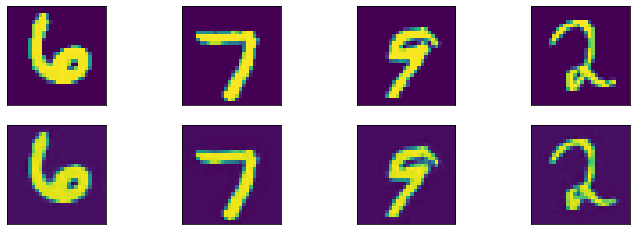

In [7]:
# This cell evaluates the performance of the autoencoder by visualising a batch of 
# in- and corresponding output images.
if EVALUATE_AUTOENCODER:
    images, _ = dataset.get_batch()
    
    # rescale images since our ae is trained on non-zero-mean images
    images += 0.5

    # get sample outputs
    output = cae(images)
    # prep images for display
    images = images.numpy()
    output = output.detach().numpy()

    # plot the first ten input images and then reconstructed images
    fig, axes = plt.subplots(nrows=2, ncols=4, sharex=True, sharey=True, figsize=(12,4))

    # input images on top row, reconstructions on bottom
    for images, row in zip([images, output], axes):
        for img, ax in zip(images, row):
            ax.imshow(np.squeeze(img))
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

# MNIST Contrastive Explanation Method <a class="anchor" id="cem_mnist"></a>

In [8]:
# In this cell the CEM object is initialised. For each parameter a short
# description is given.

# used in experiment: kappa 10, gamma 1.0, beta 0.1, c 0.1, lr 0.01

# to understand the impact of the following parameters please refer
# to the paper in this github.
kappa = 10
gamma = 1.0
beta = 0.1
c = 0.1
lr = 0.01

# number of iterations to train for
iterations = 100
# number of searches (equal to the number of times c gets updated)
n_searches = 3
# initial c value, in the original implementation the value for c 
# was initiated at 10 to prevent unnecessary iterations in which
# no weight updates are performed.
c_init = 10.0

# print information during training
verbose = True
print_every = 50

# the shape of a single sample, this is used to reshape input
# and output of the classifier and autoencoder
input_shape = (1, 28, 28)

# Select either PP for pertinent postive or PN for pertinent negative
mode = "PP"

CEM = ContrastiveExplanationMethod(
    cnn,
    cae,
    iterations=iterations,
    n_searches=n_searches,
    kappa=kappa,
    gamma=gamma,
    beta=beta,
    learning_rate=lr,
    c_init=c_init,
    c_converge=c,
    verbose=verbose,
    print_every=print_every
)

# Example usage of MNIST Contrastive Explanation Method <a class="anchor" id="eval_cem_mnist"></a>

search: 0 iteration: 50 c: 10.00 loss: 138.56 solution: False
search: 0 iteration: 100 c: 10.00 loss: 138.56 solution: False
new best delta found, loss: 81.19241333007812
new best delta found, loss: 73.32437896728516
new best delta found, loss: 71.27554321289062
search: 1 iteration: 50 c: 100.00 loss: 97.40 solution: True
new best delta found, loss: 66.89830017089844
new best delta found, loss: 63.62762451171875
search: 1 iteration: 100 c: 100.00 loss: 306.96 solution: True
search: 2 iteration: 50 c: 50.05 loss: 111.60 solution: True
new best delta found, loss: 63.59101867675781
search: 2 iteration: 100 c: 50.05 loss: 450.61 solution: True
original image classified as: 1
pertinent positive classified as: 1


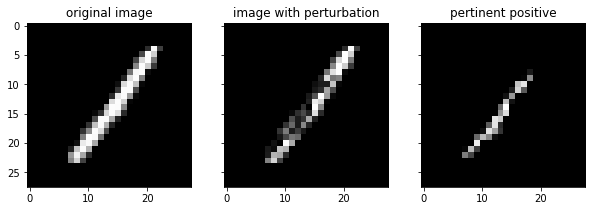

In [9]:
sample, _ = dataset.get_sample()
delta = CEM.explain(sample, mode=mode)

if delta is None:
    print("no solution found...")
    raise

before = torch.argmax(cnn(sample.view(-1, *input_shape)))

print("original image classified as: {}".format(before))

if mode == "PP":
    after = np.argmax(cnn(sample-delta.view(-1, *input_shape)).detach().cpu()).item()
    print("pertinent positive classified as: {}".format(after))

elif mode == "PN":
    after = np.argmax(cnn(delta.view(-1, *input_shape)).detach().cpu()).item()
    print("image with pertinent negative added classified as: {}".format(after))

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(10, 5))

ax1.imshow(sample.squeeze(), cmap="gray")
ax1.title.set_text("original image")

ax2.imshow(delta.view(28, 28), cmap="gray")
ax2.title.set_text("image with perturbation")

if mode == "PP":
    ax3.imshow(sample.squeeze() - delta.view(28, 28), cmap="gray")
    ax3.title.set_text("pertinent positive")
elif mode == "PN":
    ax3.imshow(delta.view(28, 28) - sample.squeeze(), cmap="gray")
    ax3.title.set_text("pertinent negative")


# Performance of the CEM on the FashionMNIST dataset <a class="anchor" id="potcotfd"></a>

In [10]:
dataset = FashionMNIST(batch_size=64, download=DOWNLOAD_FASHION_MNIST)

# Training the Fashion MNIST classifier <a class="anchor" id="training_fashion_mnist_classifier"></a>

This section trains the classifier for which the pertinent positives and negatives will be constructed.
If a load path is given and exists a model will be loaded from said file and will not train.

In [11]:
cnn = CNN()

train_cnn(cnn, dataset, load_path="./cem/models/saved_models/fashion-mnist-cnn.h5")

In [12]:
images, _ = dataset.get_batch()

output = cnn(images)

images = images.numpy()
output = output.detach().numpy()

In [13]:
# This cell evaluates the performance of the CNN on the specified test set.
if EVALUATE_CNN:

    total_acc = 0
    total_batches = 0
    for step, (batch_inputs, batch_targets) in enumerate(dataset.test_loader):

        predictions = cnn(batch_inputs)
        acc = (predictions.argmax(1).cpu().numpy() == batch_targets.cpu().numpy()).sum()/(predictions.shape[0])
        total_batches += 1
        total_acc += acc

    print("acc: {}".format(total_acc / total_batches))

acc: 0.8946058917197452


# Training the Fashion MNIST autoencoder<a class="anchor" id="training_fashion_mnist_ae"></a>

In [14]:
# Train or load autoencoder
cae = CAE(device="cpu")

train_ae(cae, dataset, iterations=10, save_fn="fashion-mnist-cae", device="cpu", load_path="./cem/models/saved_models/fashion-mnist-cae.h5")

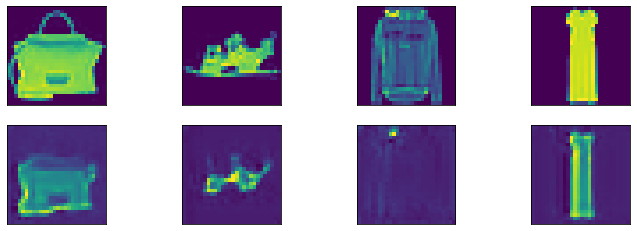

In [15]:
# This cell evaluates the performance of the autoencoder by visualising a batch of 
# in- and corresponding output images.
if EVALUATE_AUTOENCODER:
    images, _ = dataset.get_batch()
    images += 0.5 # rescale images

    # get sample outputs
    output = cae(images)
    # prep images for display
    images = images.numpy()
    output = output.detach().numpy()

    # plot the first ten input images and then reconstructed images
    fig, axes = plt.subplots(nrows=2, ncols=4, sharex=True, sharey=True, figsize=(12,4))

    # input images on top row, reconstructions on bottom
    for images, row in zip([images, output], axes):
        for img, ax in zip(images, row):
            ax.imshow(np.squeeze(img))
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

# Fashion MNIST Contrastive Explanation Method <a class="anchor" id="cem_fashion_mnist"></a>

In [16]:
# In this cell the CEM object is initialised. For each parameter a short
# description is given.

# used in experiment: kappa 10, gamma 1.0, beta 0.1, c 0.1, lr 0.01

# to understand the impact of the following parameters please refer
# to the paper in this github.
kappa = 10
gamma = 1.0
beta = 0.1
c = 0.1
lr = 0.01

# number of iterations to train for
iterations = 100
# number of searches (equal to the number of times c gets updated)
n_searches = 3
# initial c value, in the original implementation the value for c 
# was initiated at 10 to prevent unnecessary iterations in which
# no weight updates are performed.
c_init = 10.0

# print information during training
verbose = True
print_every = 50

# the shape of a single sample, this is used to reshape input
# and output of the classifier and autoencoder
input_shape = (1, 28, 28)

# Select either PP for pertinent postive or PN for pertinent negative
mode = "PP"

CEM = ContrastiveExplanationMethod(
    cnn,
    cae,
    iterations=iterations,
    n_searches=n_searches,
    kappa=kappa,
    gamma=gamma,
    beta=beta,
    learning_rate=lr,
    c_init=c_init,
    c_converge=c,
    verbose=verbose,
    print_every=print_every
)

# Example usage of Fashion MNIST Contrastive Explanation Method <a class="anchor" id="eval_cem_fashion_mnist"></a>

new best delta found, loss: 264.59136962890625
new best delta found, loss: 13.1387939453125
new best delta found, loss: 12.135979652404785
new best delta found, loss: 7.947312355041504
new best delta found, loss: 6.0954484939575195
new best delta found, loss: 5.265645980834961
new best delta found, loss: 3.6525661945343018
search: 0 iteration: 50 c: 10.00 loss: 21.06 solution: True
new best delta found, loss: 1.556190013885498
new best delta found, loss: 1.2803924083709717
search: 0 iteration: 100 c: 10.00 loss: 70.50 solution: True
search: 1 iteration: 50 c: 5.05 loss: 4.55 solution: True
new best delta found, loss: 1.078169345855713
search: 1 iteration: 100 c: 5.05 loss: 55.91 solution: True
search: 2 iteration: 50 c: 2.57 loss: 14.05 solution: True
search: 2 iteration: 100 c: 2.57 loss: 28.52 solution: True
original image classified as: 3
pertinent positive classified as: 3


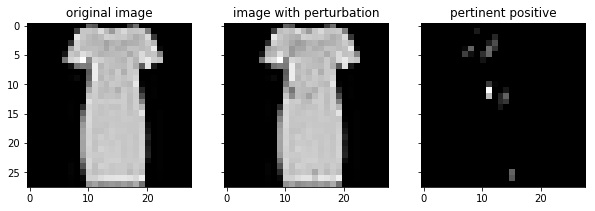

In [17]:
sample, _ = dataset.get_sample()
delta = CEM.explain(sample, mode=mode)

if delta is None:
    print("no solution found...")
    raise

before = torch.argmax(cnn(sample.view(-1, *input_shape)))

print("original image classified as: {}".format(before))

if mode == "PP":
    after = np.argmax(cnn(sample-delta.view(-1, *input_shape)).detach().cpu()).item()
    print("pertinent positive classified as: {}".format(after))

elif mode == "PN":
    after = np.argmax(cnn(delta.view(-1, *input_shape)).detach().cpu()).item()
    print("image with pertinent negative added classified as: {}".format(after))

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(10, 5))

ax1.imshow(sample.squeeze(), cmap="gray")
ax1.title.set_text("original image")

ax2.imshow(delta.view(28, 28), cmap="gray")
ax2.title.set_text("image with perturbation")

if mode == "PP":
    ax3.imshow(sample.squeeze() - delta.view(28, 28), cmap="gray")
    ax3.title.set_text("pertinent positive")
elif mode == "PN":
    ax3.imshow(delta.view(28, 28) - sample.squeeze(), cmap="gray")
    ax3.title.set_text("pertinent negative")
